# M2177.003100 Deep Learning Assignment #1<br> Part 1-1. Training Convolutional Neural Networks (Pytorch)

Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Jaehoon Lee, September 2023

**For understanding of this work, please carefully look at given PDF file.**

Now, you're going to leave behind your implementations and instead migrate to one of popular deep learning frameworks, **PyTorch**. <br>
In this notebook, you will learn how to train convolutional neural networks (CNNs) for classifying images in the CIFAR-10 dataset. <br>
There are **3 sections**, and in each section, you need to follow the instructions to complete the skeleton codes and explain them.

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results. 

### Some helpful tutorials and references for assignment #1-1:
- [1] Pytorch official documentation. [[link]](https://pytorch.org/docs/stable/index.html)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Szegedy et al., "Going deeper with convolutions", CVPR 2015. [[pdf]](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf)

## 1. Load datasets
The CIFAR-10 dataset will be downloaded automatically if it is not located in the *data* directory. <br>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=8,
                                          shuffle=True, num_workers=2)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=8,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

(36, 274, 3)


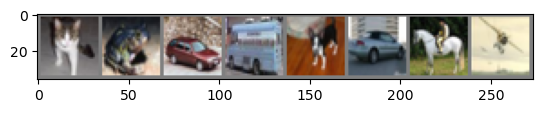

  cat  frog   car truck
torch.Size([3, 32, 32])


In [4]:
# get some random training images
images, labels = next(iter(dataloader_train))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# print size of single image
print(images[1].shape)

## 2. Training a small CNN model

#### CNN architecture in order:
* 7x7 Convolutional layer with 8 filters, strides of 1, and ReLU activation
* 2x2 Max pooling layer with strides of 2
* 4x4 Convolutional layer with 16 filters, strides of 1, and ReLU activation
* 2x2 Max pooling layer with strides of 2
* Fully connected layer with 100 output units and ReLU activation
* Fully connected layer with 80 output units and ReLU activation
* Fully connected layer with 10 output units 
* You can use any padding option.

#### Training setup:
* Loss function: Softmax cross entropy
* Optimizer: Gradient descent with 0.001 learning rate
* Batch size: 8
* Training epoch: 2

In [5]:
# Define a CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Flatten(),
            
            nn.Linear(1024, 100),
            nn.ReLU(),
            
            nn.Linear(100, 80),
            nn.ReLU(),

            nn.Linear(80, 10),
            nn.ReLU(),
        )
        
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

    def forward(self, x):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        x = self.layer(x)
        
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
        return x


In [6]:
# Function to train the network

def train(net, dataloader_train, max_epoch, crit, optimizer, device, model_path='./cifar_net.pth'):

    for epoch in range(max_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(dataloader_train, 0):
            # get the inputs; data is a list of [inputs, targets]
            inputs, targets = data
        
            # Training on GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = crit(outputs, targets)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), model_path)
    print('Saved Trained Model')

In [7]:
PATH = './cifar_net.pth'
epoch = 2

# initialize model
net = Net()

# Training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train(net, dataloader_train, epoch, criterion, optimizer, device, PATH)

[1,  2000] loss: 2.173
[1,  4000] loss: 1.747
[1,  6000] loss: 1.544
[2,  2000] loss: 1.430
[2,  4000] loss: 1.356
[2,  6000] loss: 1.315
Finished Training
Saved Trained Model


In [8]:
# function to calculate accuracy
def print_accuracy(net, dataloader):
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            # Inference on GPU
            images = images.to(device)
            labels = labels.to(device)
        
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    print('Accuracy of the network on the %d test images: %d %%' % (total,
        100 * correct / total))

In [9]:
# load trained model then test
net.load_state_dict(torch.load(PATH))
print_accuracy(net, dataloader_test)

Accuracy of the network on the 10000 test images: 55 %


## <a name="3-1"></a>3-1. Design an Inception module

In this section, you will implement a little more complex CNN model with an `Inception module`. <br>

![Inception_module](imgs/Inception.png)

Using the code provided as guidance, <br>
Define an `inception module`, which is the building block of **Inception model (a.k.a GoogLeNet)**, the winner of ILSVRC14. <br>


#### CNN architecture:
* CNN model consists with stem layer, inception module, and fully connected layer
* Stem layer with
    * conv-pooling-conv-pooling
    * 8 filters for the 9x9 convolutions
    * 3x3 max pooling
* `Inception module` with 
    * 3(or 4) main convolutions (blue blocks in the Figure(a))
    * 3 dimensionality reduction convolutions (yellow blocks in the Figure(a))
    * 3x3 max pooling block (red blocks in the Figure(a))
    * Batch Nomalization and ReLU activation after all conv layer
* Fully connected layer with 10 output units and linear activation
* Choose the proper padding option on your own.

In [10]:
'''
About parameter
in_planes : # of input channel
n1xn1 : # of output channel for first branch
n3xn3_blue : # of output channel for second branch's 1x1 conv layer
n3xn3 : # of output channel for second branch
n5xn5_blue : # of output channel for third branch's 1x1 conv layer
n5xn5 : # of output channel for third branch
pool_planes : # of output channel for fourth branch

'''
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3_blue, n3x3, n5x5_blue, n5x5, pool_planes):
        super(Inception, self).__init__()
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        # 1x1 conv branch
        self.b1 = nn.Conv2d(in_planes, n1x1, kernel_size=1)

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3_blue, kernel_size=1),
            nn.Conv2d(n3x3_blue, n3x3, kernel_size=3, padding=1)
        )
        
        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5_blue, kernel_size=1),
            nn.Conv2d(n5x5_blue, n5x5, kernel_size=5, padding=2)
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1)
        )

        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

## <a name="3-2"></a>3-2. Design an Residual Block module

In this section, you will implement a little more complex CNN model with a `Residual block`. <br>

![Residual_block](imgs/Residualblock.png)

Using the code provided as guidance, <br>
Define a `residual block module`, which is the building block of **Residual neural network (a.k.a ResNet)**, the winner of ILSVRC15. <br>


#### CNN architecture:
* A residual block consists of convolutional layers, bach normalization, ReLU actication functions, and Shortcut Connection.
* Define the Short Connection which directly connects the input of the block to the output.
* The shortcut module must be sequential layers that contain:
    * 1 convolution of kernel size 1
    * 1 batch normalization layer

In [11]:


# Define the residual block class
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # The first convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # The second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection (identity mapping)
        if stride != 1 or in_channels != out_channels:
            ############################################################################## 
            #                        IMPLEMENT OF YOUR CODE                       #
            ##############################################################################
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

            ############################################################################## 
            #                           END OF YOUR CODE                          #
            ##############################################################################
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x):
        # Pass through the first convolutional layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = nn.ReLU()(out)
        
        # Pass through the second convolutional layer
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Shortcut connection
        shortcut = self.shortcut(x)
        
        # Add the output and the shortcut and pass it through a relu activation layer for the final output. (Residual connection implementation)
        ############################################################################## 
            #                        IMPLEMENT OF YOUR CODE                       #
        ##############################################################################
        out += shortcut
        out = nn.ReLU()(out)
        
        ############################################################################## 
            #                        IMPLEMENT OF YOUR CODE                       #
        ##############################################################################
        return out

## <a name="3-3"></a>3-3. Design a better model on CIFAR-10

Now it's your job to experiment with CNNs to train a model that achieves **<font color=red>>= 70% accuracy on the validation set</font>** of CIFAR-10. <br> You can reuse the implemented functions from above.

### Things you can try to change:
- Filter size
- Number of filters
- Pooling vs Strided Convolution
- Network architectures
- Optimizers
- Activation functions
- Regularizations
- Model ensembles
- Data augmentation
- learning rate scheduler

In [12]:
# Define a CNN model
class BetterNet(nn.Module):
    def __init__(self):
        super(BetterNet, self).__init__()
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        repeat_block = 2
        
        self.model = nn.Sequential(
            ResidualBlock(3, 64),
            *[ResidualBlock(64, 64) for _ in range(repeat_block)],
            nn.MaxPool2d(kernel_size=2 ,stride=2),

            ResidualBlock(64, 128),
            *[ResidualBlock(128, 128) for _ in range(repeat_block)],
            nn.MaxPool2d(kernel_size=2 ,stride=2),

            ResidualBlock(128, 256),
            *[ResidualBlock(256, 256) for _ in range(repeat_block)],
            nn.MaxPool2d(kernel_size=2 ,stride=2),
            
            nn.Flatten(),
            nn.Linear(4096, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            nn.Softmax(dim=1)
        )
        
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

    def forward(self, x):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        out = self.model(x)
        
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
        return out


In [13]:
# initialize model
betternet = BetterNet()
betternet = betternet.to(device)

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(betternet.parameters(), lr=0.001, momentum=0.9)

PATH = './better_net.pth'
# Train
train(betternet, dataloader_train, 10, criterion, optimizer, device, PATH)
# Test
betternet.load_state_dict(torch.load(PATH))
print_accuracy(betternet, dataloader_test)

[1,  2000] loss: 2.126
[1,  4000] loss: 2.043
[1,  6000] loss: 1.987
[2,  2000] loss: 1.940
[2,  4000] loss: 1.907
[2,  6000] loss: 1.876
[3,  2000] loss: 1.850
[3,  4000] loss: 1.844
[3,  6000] loss: 1.836
[4,  2000] loss: 1.825
[4,  4000] loss: 1.821
[4,  6000] loss: 1.821
[5,  2000] loss: 1.809
[5,  4000] loss: 1.804
[5,  6000] loss: 1.804
[6,  2000] loss: 1.796
[6,  4000] loss: 1.778
[6,  6000] loss: 1.778
[7,  2000] loss: 1.787
[7,  4000] loss: 1.756
[7,  6000] loss: 1.768
[8,  2000] loss: 1.760
[8,  4000] loss: 1.757
[8,  6000] loss: 1.760
[9,  2000] loss: 1.759
[9,  4000] loss: 1.755
[9,  6000] loss: 1.754
[10,  2000] loss: 1.743
[10,  4000] loss: 1.748
[10,  6000] loss: 1.752
Finished Training
Saved Trained Model
Accuracy of the network on the 10000 test images: 72 %


### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

You can write in Korean

- 간단한 CNN 모델, Inception module, Residual block을 구현해보았다. 위에 기록을 남기진 않았지만, Inception module을 사용해서도 BetterNet을 구성해보았으나 속도와 정확도를 고려할 때 Residual Block 을 활용하는 편이 더 좋았다.
- BetterNet의 구성은 ResNet의 대략적인 형태를 따랐다.
- 최대한 좋은 성능을 얻어보려고 BetterNet 안에 아주 많은 Residual block을 넣어보기도 했는데, 그에 따라 학습 속도도 매우 느려져 모델의 복잡성과 학습 및 추론의 속도 사이의 trade-off를 관찰할 수 있었다. 위에서는 기본적으로 주어진 10 epoch 안에 학습을 마치고서 70%의 정확도를 넘기도록 적당한 모델을 구성해 넣었다.